In [338]:
import logging

import numpy as np
from time import time
from scipy.stats import multivariate_normal
import numpy.linalg as LA 

import imageio as io
from PIL import Image
from scipy import misc
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [268]:
import warnings
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

## Load images & generate rescales

In [269]:
### Global Parameters used in the paper
NB_OCTAVES = 4
NB_OCTAVE_LAYERS = 3

#K = np.sqrt(2)
K = 2**(1/NB_OCTAVE_LAYERS)
SIGMA = 1.6
DOG_THRESHOLD = 0.03
EDGE_THRESHOLD = 10 
X_HAT_THRESHOLD = 0.5

In [272]:
### Utils
def image2nparray(img):
    """Convert Image object to a numpy array with values between 0. and 1.
    
    Parameters:
    ----------
    img::py:class:`~PIL.Image.Image`.
        Input image.
    
    Returns:
    -------
    out : ndarray
        Array interpretation of `img`.
    """
    return np.asarray(img,dtype='float64')/255.
    
def show_gray(img):
    """Plot a gray scale image.
    
    Parameters:
    ----------
    img: ndarray
        Input image.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

Why start by upsampling the image?
> If we pre-smooth the image before extrema detection, we are effectively discarding the highest spatial frequencies. Therefore, to make full use of the input, the image can be expanded to create more sample points than were present in the original. We double the size of the input image using linear interpolation prior to building the first level of the pyramid.

Why not upsample the image even more? 
> The image doubling increases the number of stable keypoints by almost a factor of 4, but no significant further improvements were found with a larger expansion factor.

In [479]:
def load_gray_octaves(imagename, nb_octaves = NB_OCTAVES, presampling = 1):
    """Loads image and performs 2x, 1x, 0.5x rescaling.

    Parameters:
    ----------
    imagename: str
        Image filename.
    nb_octaves: int, optional
        Number of octaves in the scale pyramid. Default is NB_OCTAVES.
    presampling: int, optional
        Downsample the original image by a factor of `presampling` before building the pyramid. Default is 1
        
    Returns:
    -------
    out : list
        List of scaled images.
    """
    img = Image.open(imagename).convert('L') # Load image in gray scale
    h, w = img.size
       
    scaled_imgs = [ img.resize((2*h//presampling, 2*w//presampling), resample = Image.BILINEAR) ] # double sized image, downscaled if specified
    
    for octave in range(nb_octaves-1):
        h, w = scaled_imgs[-1].size
        scaled_img = scaled_imgs[0].resize((h//2,w//2), resample=Image.BILINEAR)
        scaled_imgs.append(scaled_img)
        
    gray_scaled_imgs = [image2nparray(scaled_img) for scaled_img in scaled_imgs]

    return gray_scaled_imgs

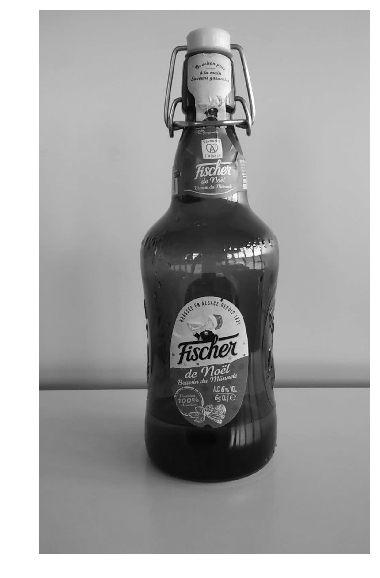

In [480]:
template_image = 'data/template.jpg'
scaled_imgs = load_gray_octaves(TEMPLATE_IMAGE, presampling = 2)
show_gray(scaled_imgs[0]) # plot doubled image

## Sigmas for gaussian filter

How was sigma chosen?
> the top line is the repeatability of keypoint detection, and the results show that the repeatability continues to increase with σ . However, there is a cost to using a large σ in terms of efficiency, so we have chosen to use σ = 1.6, which provides close to optimal repeatability.

The initial image is incrementally convolved with Gaussians to produce images separated by a constant factor k in scale space.
How was k chosen?
> We choose to divide each octave of scale space (i.e., doubling of σ ) into an integer number, s, of intervals, so k = 2**1/s . We must produce s + 3 images in the stack of blurred images for each octave, so that final extrema detection covers a complete octave. 

Where to start for the next octave?
> Once a complete octave has been processed, we resample the Gaussian image that has twice the initial value of σ (it will be 2 images from the top of the stack) by taking every second pixel in each row and column.

In [485]:
def sigmas_for_octave_layer(octave, nb_octave_layers = NB_OCTAVE_LAYERS + 3, k = K, sigma = SIGMA):
    """Compute sigmas used to perform gaussain filtering. 
    
    Parameters:
    ----------
    octave: int
        Octave number.
    nb_octave_layers: int, optional
        Number of layers in the octave.
    k: float, optional
        Seperation factor in the scale space
    sigma: float, optional
        Inital sigma
    
    Returns:
    -------
    out : ndarray
        Array of sigmas for the given octave.
    """
    k_offset = 2 * octave  
    octave_sigmas = sigma * np.power(k, k_offset+np.arange(nb_octave_layers))

    logging.info('Octave #{} - Sigmas: {} - k_offset: {}'.format(octave, list(np.round(octave_sigmas,2)), k_offset))    
    return octave_sigmas

In [486]:
SIGMAS = [ sigmas_for_octave_layer(octave) for octave in range(NB_OCTAVES) ]

INFO:root:Octave #0 - Sigmas: [1.6, 2.02, 2.54, 3.2, 4.03, 5.08] - k_offset: 0
INFO:root:Octave #1 - Sigmas: [2.54, 3.2, 4.03, 5.08, 6.4, 8.06] - k_offset: 2
INFO:root:Octave #2 - Sigmas: [4.03, 5.08, 6.4, 8.06, 10.16, 12.8] - k_offset: 4
INFO:root:Octave #3 - Sigmas: [6.4, 8.06, 10.16, 12.8, 16.13, 20.32] - k_offset: 6


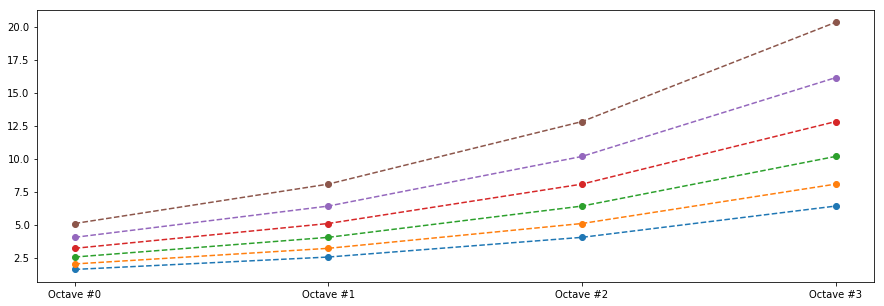

In [487]:
### Plot sigmas
plt.figure(figsize=(15,5))
plt.plot(SIGMAS, 'o--')
#plt.legend(["Octave #%d" %i for i in range(NB_OCTAVES)])
plt.xticks(range(NB_OCTAVES), ["Octave #%d" %i for i in range(NB_OCTAVES)])
plt.show()

## Applying Gaussian Filters

In [488]:
def compute_octaves(scaled_images, nb_octaves_layers = NB_OCTAVE_LAYERS+3, sigmas = SIGMAS):
    """Build scale pyramid. 
    
    Parameters:
    ----------
    scaled_images: list
        List of scaled images.
    nb_octaves_layers: int, optional
    sigmas: list, optional
    
    Returns:
    -------
    out : ndarray
        Array interpretation of `img`.
    """
    octaves = [ np.zeros((*img.shape, nb_octaves_layers)) for img in scaled_images ]
    for i_octave, octave in enumerate(octaves):
        for octave_layer in range(nb_octaves_layers):
            doubled_img = scaled_images[0]
            sigma = sigmas[i_octave][octave_layer]
            octave_size = octave.shape[:2]
            octave[:,:,octave_layer] = misc.imresize(ndimage.filters.gaussian_filter(doubled_img, sigma), size=octave_size, interp='bilinear')/255.
            
    return octaves

In [489]:
OCTAVES = compute_octaves(scaled_imgs)

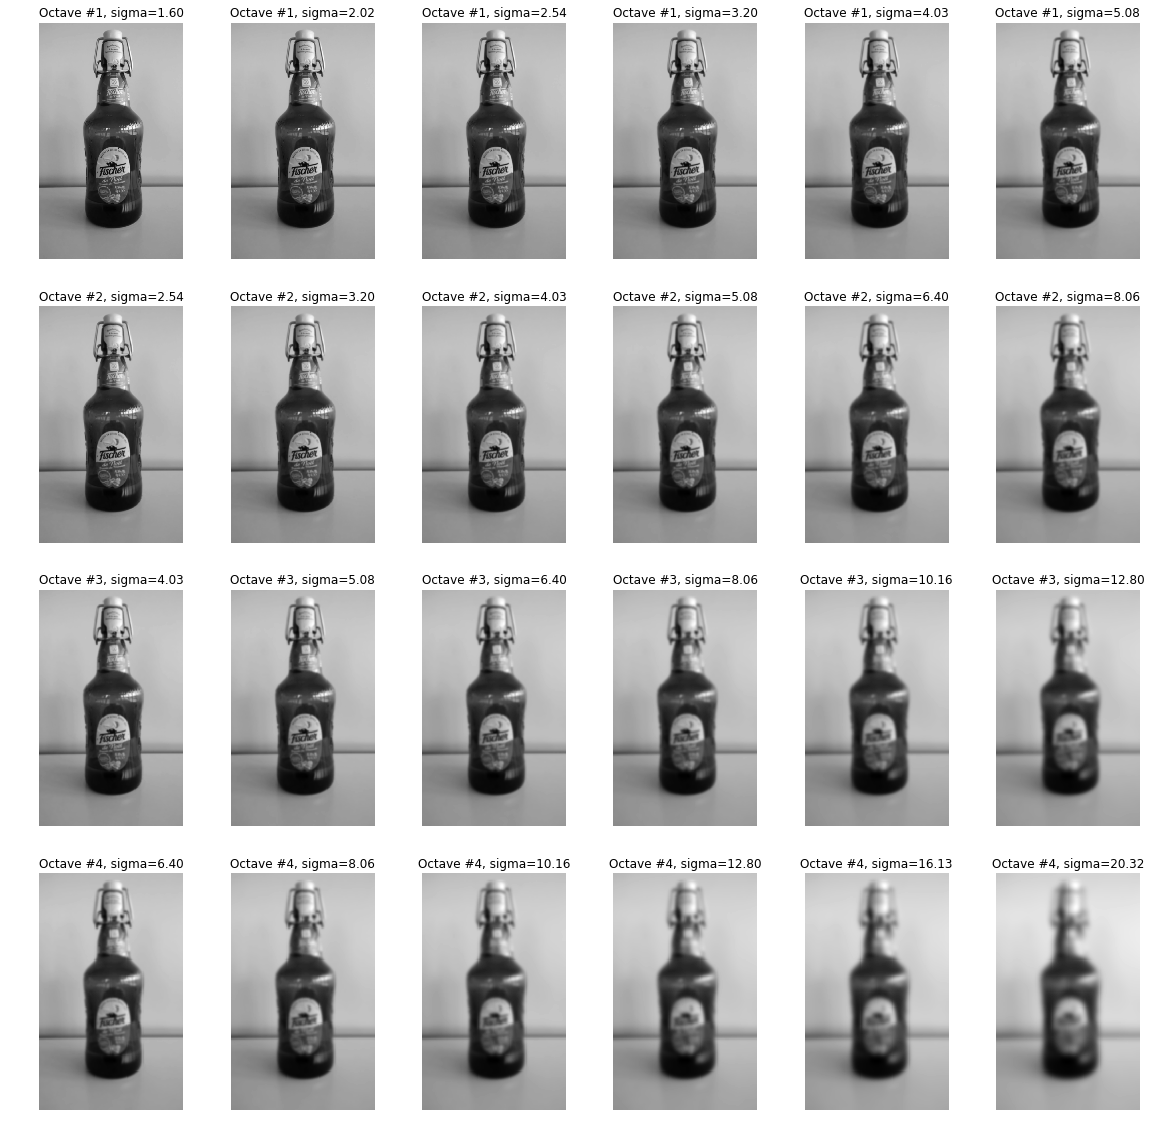

In [490]:
### Plot gaussian pyramid
plt.figure(figsize=(20,20))
for octave in range(NB_OCTAVES):
    for octave_layer in range(NB_OCTAVE_LAYERS+3):
        plt.subplot(NB_OCTAVES, NB_OCTAVE_LAYERS+3, octave_layer+(NB_OCTAVE_LAYERS+3)*octave+1)
        plt.imshow(OCTAVES[octave][:,:,octave_layer],cmap='gray')
        plt.title('Octave #%d, sigma=%.2f' %(octave+1, SIGMAS[octave][octave_layer]))
        plt.axis('off')
plt.show()

## Computing DoG pyramid

In [491]:
DoGs = [np.diff(octave, axis=-1) for octave in OCTAVES]

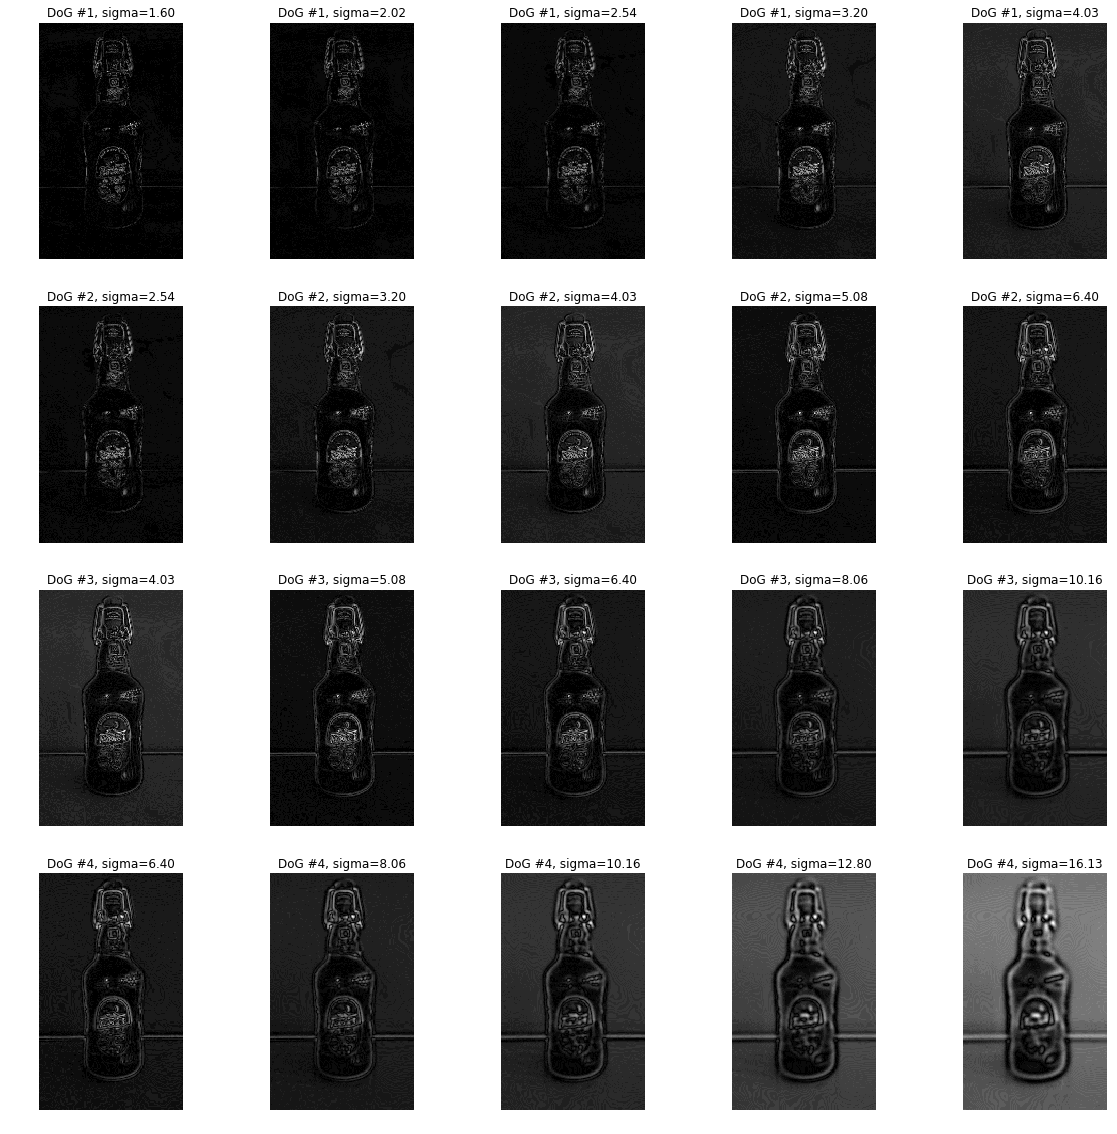

In [492]:
### Plotting Dog pyramid
def plot_dogs(dogs):
    nb_octaves = len(dogs)
    nb_dog_layers = dogs[0].shape[-1]
    
    plt.figure(figsize=(20,20))
    for octave in range(nb_octaves):
        for dog_layer in range(nb_dog_layers):
            plt.subplot(nb_octaves,nb_dog_layers, dog_layer+nb_dog_layers*octave+1)
            plt.imshow(abs(dogs[octave][:,:,dog_layer]),cmap='gray')
            plt.title('DoG #%d, sigma=%.2f' %(octave+1, SIGMAS[octave][dog_layer]))
            plt.axis('off')
    plt.show()
    
plot_dogs(DoGs)

## Extrema detection
In each of the following for loops, elements of each pyramids that are larger or smaller than its 26 immediate neighbors in space and scale are labeled as extrema. As explained in section 4 of Lowe's paper, these initial extrema are pruned by checking that their contrast and curvature are above certain thresholds. The thresholds used here are those suggested by Lowe. 

### Finding the threshold

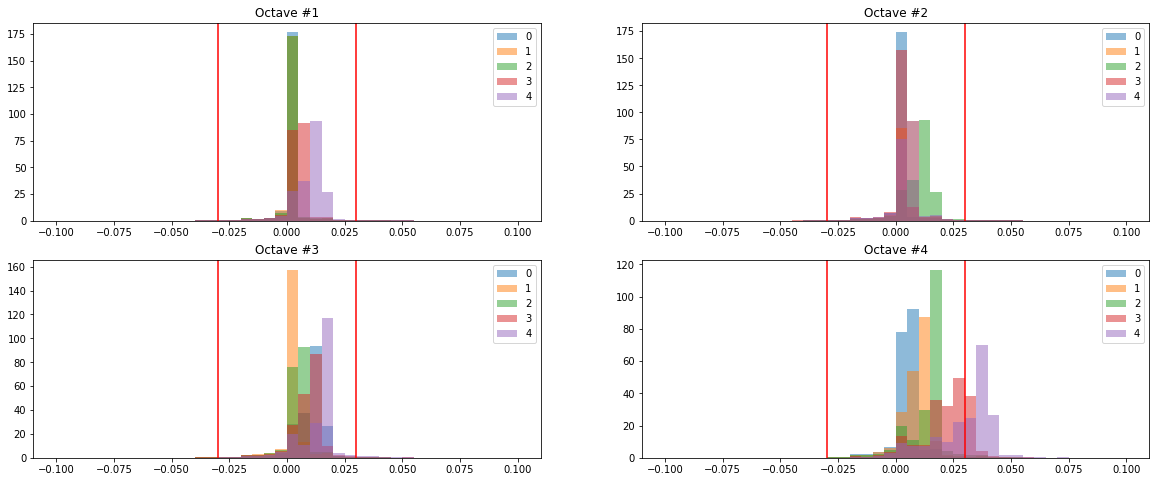

In [578]:
### To get a feel of how the threshold should be chosen. We plot the histograms of the dogs.
def plot_hist_dogs(dogs, threshold = DOG_THRESHOLD):
    """Plot dog histograms for each octave.
    
    Parameters:
    ----------
    dogs: list
        DoGs.
    """
    nb_octaves = len(dogs)
    nb_dog_layers = dogs[0].shape[-1]
    
    plt.figure(figsize=(20,8))
    for i_octave in range(nb_octaves):
        plt.subplot('22%d' %(i_octave+1))
        for i_dog_layer in range(nb_dog_layers):
            plt.hist(dogs[i_octave][:,:,i_dog_layer].reshape(-1), bins = 40, range=(-0.1, 0.1), label ='%d'%i_dog_layer, normed=True, alpha=0.5) 
        plt.axvline(x=threshold, c='r')
        plt.axvline(x=-threshold, c='r')
        plt.legend()
        plt.title('Octave #%d' %(i_octave+1))
    plt.show()
    
plot_hist_dogs(DoGs)

In [595]:
def compute_x_hat(octave_dogs, i, j, k):
    dx = (octave_dogs[j, k+1, i] - octave_dogs[j, k-1, i]) * 0.5
    dy = (octave_dogs[j+1, k, i] - octave_dogs[j-1, k, i]) * 0.5
    ds = (octave_dogs[j, k, i+1] - octave_dogs[j, k, i-1]) * 0.5
    dxx = (octave_dogs[j, k+1, i] + octave_dogs[j, k-1, i] - 2 * octave_dogs[j, k, i]) * 1.0       
    dyy = (octave_dogs[j+1, k, i] + octave_dogs[j-1, k, i] - 2 * octave_dogs[j, k, i]) * 1.0       
    dss = (octave_dogs[j, k, i+1] + octave_dogs[j, k, i-1] - 2 * octave_dogs[j, k, i]) * 1.0
    dxy = (octave_dogs[j+1, k+1, i] - octave_dogs[j+1, k-1, i] - octave_dogs[j-1, k+1, i] + octave_dogs[j-1, k-1, i]) * 0.25 
    dxs = (octave_dogs[j, k+1, i+1] - octave_dogs[j, k-1, i+1] - octave_dogs[j, k+1, i-1] + octave_dogs[j, k-1, i-1]) * 0.25 
    dys = (octave_dogs[j+1, k, i+1] - octave_dogs[j-1, k, i+1] - octave_dogs[j+1, k, i-1] + octave_dogs[j-1, k, i-1]) * 0.25  

    dD = np.matrix([[dx], [dy], [ds]])
    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
    x_hat = -np.linalg.lstsq(H, dD)[0]
    D_x_hat = octave_dogs[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)
    return x_hat, dx, dy, dxx, dyy, dxy, D_x_hat


def keypoints(octave_dogs, threshold = DOG_THRESHOLD, r = EDGE_THRESHOLD, x_hat_thresh = X_HAT_THRESHOLD):
    xextr, yextr, dxextr, dyextr, maskextr, sextr = [], [], [], [], [], []
    x_hat_l = []
    h, w = octave_dogs.shape[:2]
    for i in range(1,octave_dogs.shape[2]-1):
        for j in range(80, h - 80):
            for k in range(80, w - 80):
                if np.absolute(octave_dogs[j, k, i]) < threshold:
                    continue

                maxbool = True #(octave_dogs[j, k, i] > 0)
                minbool = True #(octave_dogs[j, k, i] < 0)

                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        for dk in range(-1, 2):
                            if di == 0 and dj == 0 and dk == 0:
                                continue

                            maxbool = maxbool and (octave_dogs[j, k, i] > octave_dogs[j + dj, k + dk, i + di])
                            minbool = minbool and (octave_dogs[j, k, i] < octave_dogs[j + dj, k + dk, i + di])
                 
                            if not maxbool and not minbool:
                                break

                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if maxbool or minbool:
                    x_hat, dx, dy, dxx, dyy, dxy, D_x_hat = compute_x_hat(octave_dogs, i, j, k)
                    maskextr.append(0)
                    j_new,k_new,i_new=j,k,i
                    
                    if np.any(np.abs(x_hat) > 1.5):
                        maskextr[-1]= -1
                        #continue
                        
                    if np.any(np.abs(x_hat) > x_hat_thresh) and np.all(np.abs(x_hat) < 1.5):
                        j_new = j + int(np.floor(x_hat[0]+x_hat_thresh))
                        k_new = k + int(np.floor(x_hat[1]+x_hat_thresh))
                        i_new = i + int(np.floor(x_hat[2]+x_hat_thresh))
                        if i_new == octave_dogs.shape[2]-1 or i_new==0:
                            i_new = i
                        x_hat, dx, dy, dxx, dyy, dxy, D_x_hat = compute_x_hat(octave_dogs, i_new, j_new, k_new)
                    
                    xextr.append(j_new)
                    yextr.append(k_new)
                    sextr.append(i_new)
                    dxextr.append(dx)
                    dyextr.append(dy) 
                    x_hat_l.append(x_hat)
                        
                    if np.all(np.abs(x_hat) < x_hat_thresh):
                        maskextr[-1]=1
                    
                        if np.absolute(D_x_hat) > threshold:
                            maskextr[-1]=2
                            
                            trace = dxx + dyy
                            det = dxx * dyy - (dxy ** 2)
                    
                            if (trace ** 2) * r < det * ((r + 1) ** 2):
                                #extrpyrlvl1[j, k, i - 1] = 1
                                maskextr[-1] = 3
                                
    return np.array(xextr), np.array(yextr), np.array(sextr), np.array(dxextr), np.array(dyextr), np.array(maskextr), np.array(x_hat_l)

In [596]:
def keypoints_all_octaves(dogs, threshold = DOG_THRESHOLD, r = EDGE_THRESHOLD, x_hat_thresh = X_HAT_THRESHOLD):
    all_keypoints = list()
    
    for i_dog, dog in enumerate(DoGs):
        start = time()
        all_keypoints.append(keypoints(dog, threshold, r, x_hat_thresh))
        logging.info('Keypoint for DoG #{} - {}sec'.format(i_dog, round(time()-start, 1)))
        
    return all_keypoints
        
all_kp = keypoints_all_octaves(DoGs, r = 3)

INFO:root:Keypoint for DoG #0 - 9.2sec
INFO:root:Keypoint for DoG #1 - 1.8sec
INFO:root:Keypoint for DoG #2 - 0.2sec
INFO:root:Keypoint for DoG #3 - 0.0sec


(-3, 3)

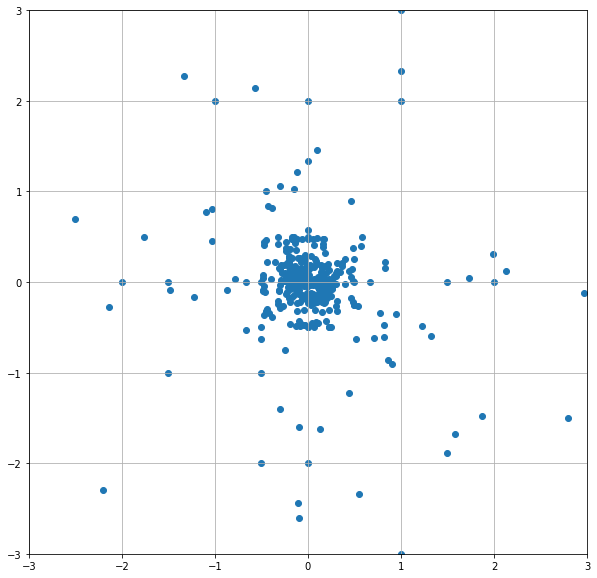

In [597]:
plt.figure(figsize=(10,10))
plt.scatter(all_kp[0][-1][:,0,0],all_kp[0][-1][:,1,0])
plt.grid()
plt.xlim([-3,3])
plt.ylim([-3,3])

In [497]:
# xextr, yextr, dxextr, dyextr, maskextr = keypoints(DoGs[0])

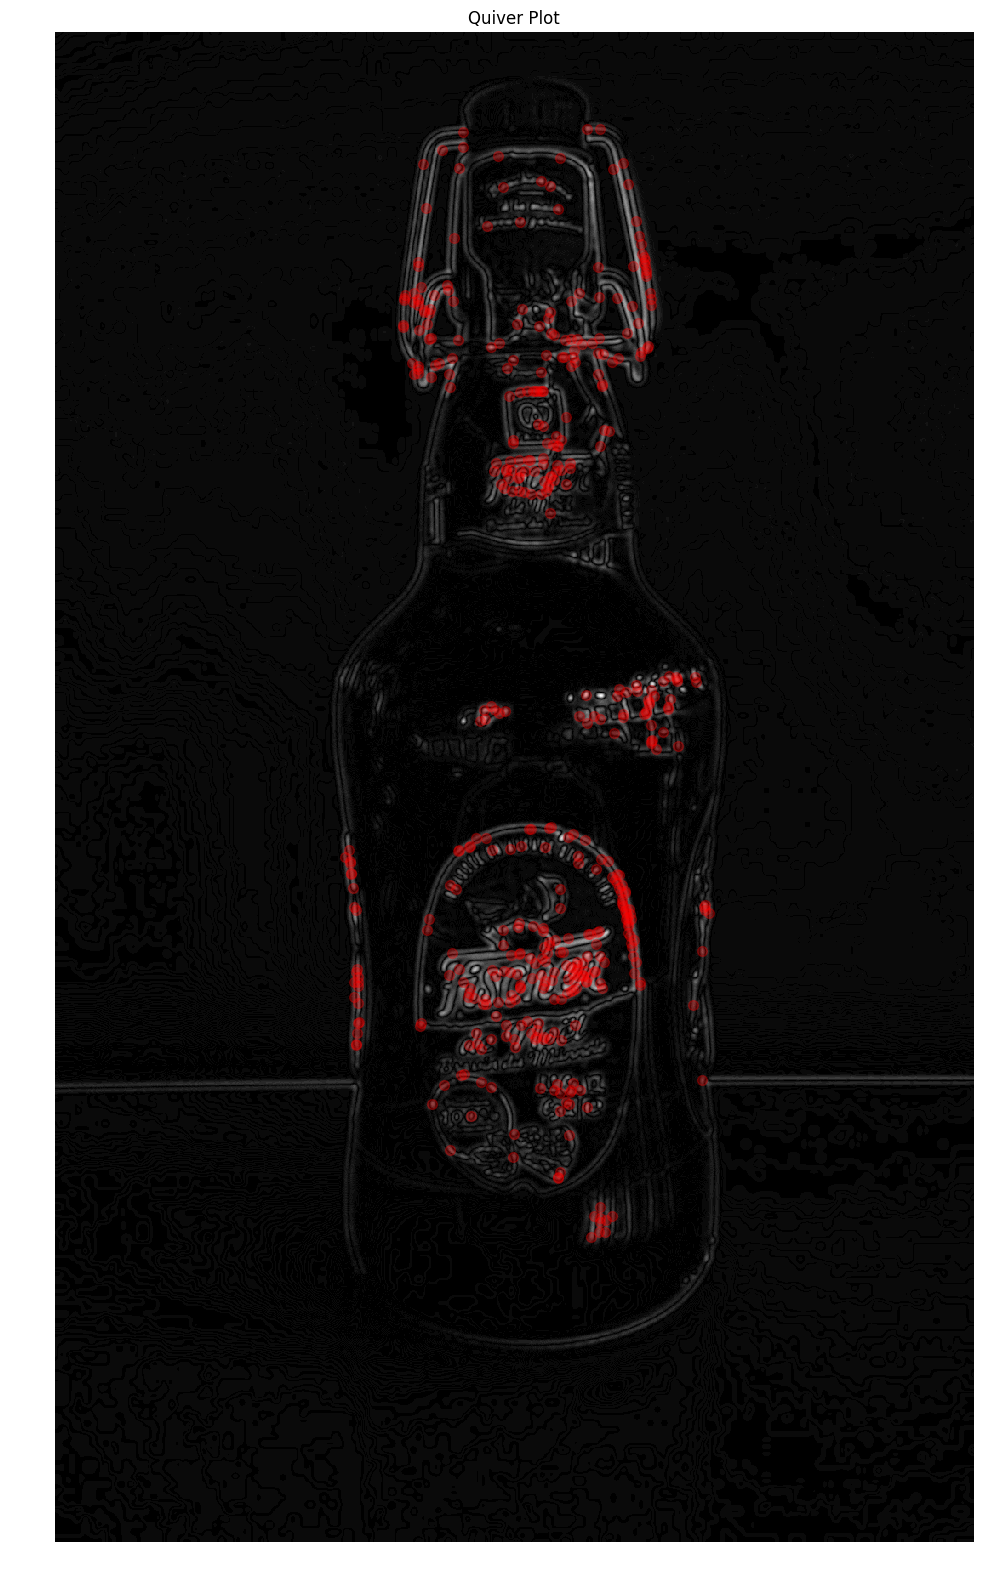

In [607]:
def plot_keypoints(scaled_img, mask_level, xextr, yextr, sextr, dxextr, dyextr, maskextr, _):
    
    mask = maskextr >= -1
        
    fig, ax = plt.subplots(figsize=(15,20), dpi=100)
    plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    
    plt.scatter(yextr[mask], xextr[mask], color='red',alpha=0.3, s=50) #, dyextr[mask], dxextr[mask], color='blue', norm=None,scale=0.075)
    
    #c_map = [colors[mask_lvl] for mask_lvl in maskextr[mask]]

    ax.set(aspect=1, title='Points Caracteristiques')
    plt.show()

octave_lvl = 0
plot_keypoints(np.abs(DoGs[octave_lvl][:,:,2]), 1, *all_kp[octave_lvl])

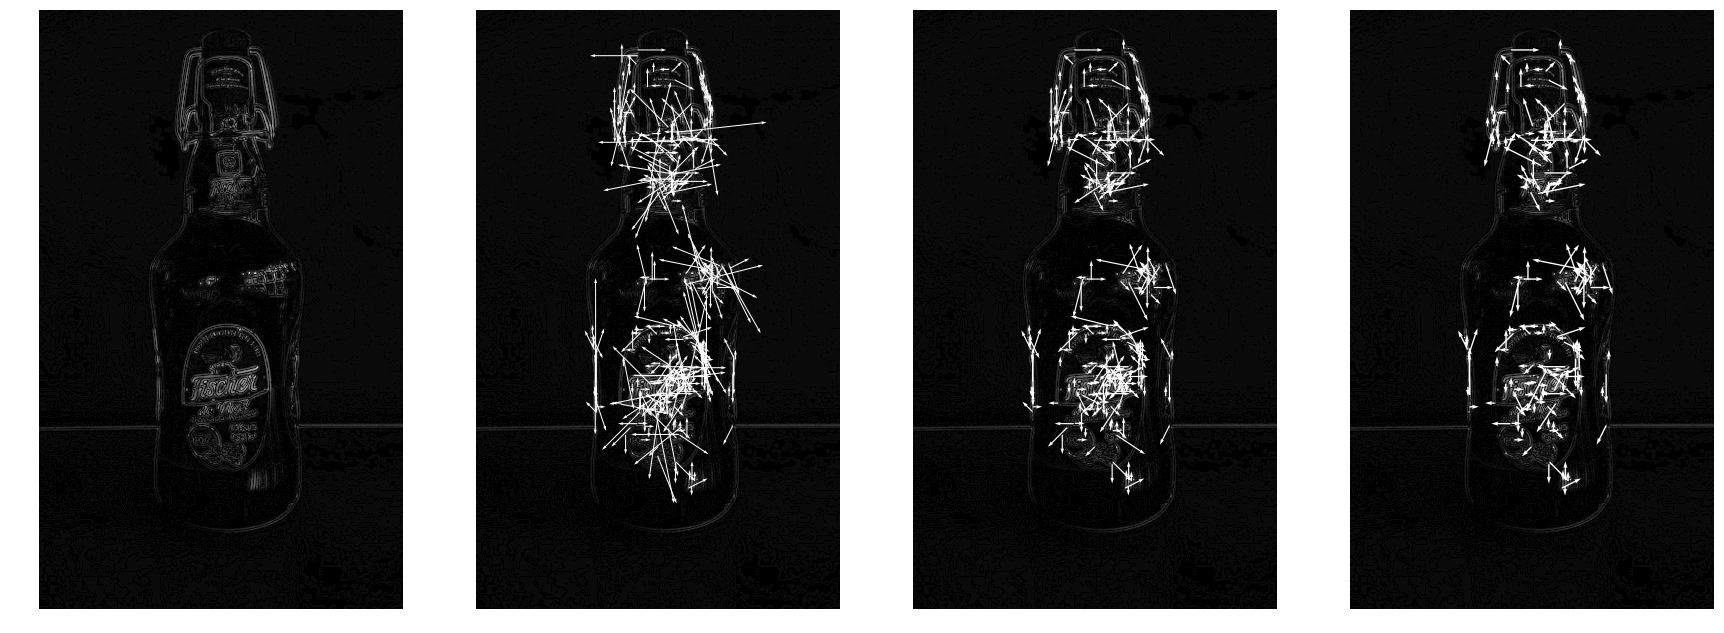

In [601]:
def plot_keypoints(scaled_img, mask_level, xextr, yextr, sextr, dxextr, dyextr, maskextr, _):
    
    mask = maskextr >= mask_level
    
    colors = {0:'black',1: 'red', 2: 'blue', 3: 'yellow'}
    
    fig, ax = plt.subplots(figsize=(30,40))
    plt.subplot('141'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    
    plt.subplot('142'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    mask = maskextr >= -1
    plt.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color='white', norm=None,scale=0.075)
    
    plt.subplot('143'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    mask = maskextr >= 2
    plt.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color='white', norm=None,scale=0.075)

    plt.subplot('144'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    mask = maskextr >= 3
    plt.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color='white', norm=None,scale=0.075)

    
    #c_map = [colors[mask_lvl] for mask_lvl in maskextr[mask]]

    ax.set(aspect=1, title='Quiver Plot')
    plt.show()

octave_lvl = 0
plot_keypoints(np.abs(DoGs[octave_lvl][:,:,2]), 1, *all_kp[octave_lvl])

In [593]:
len(all_kp[0][0])

2449

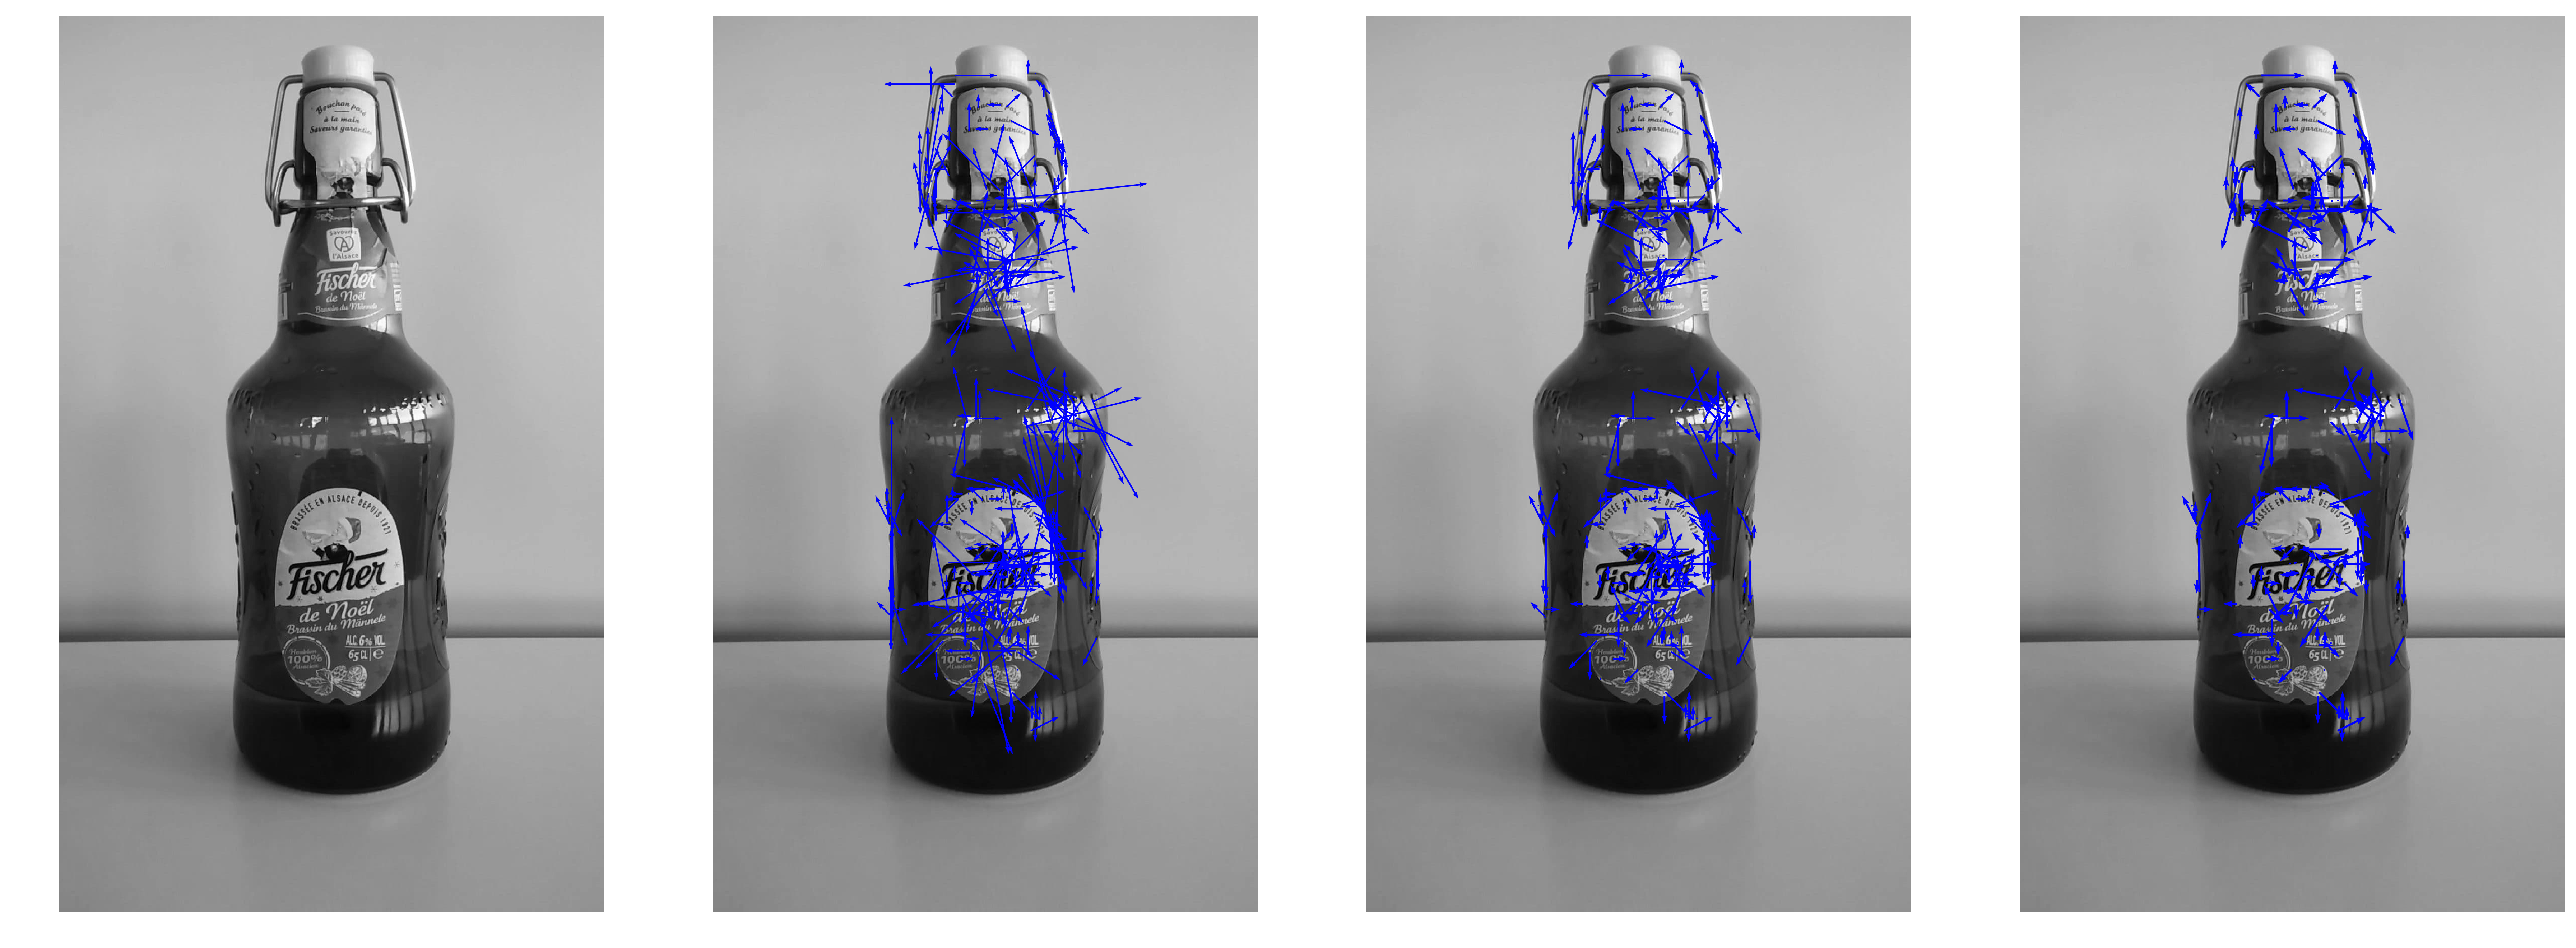

In [561]:
def plot_keypoints(scaled_img, mask_level, xextr, yextr, sextr, dxextr, dyextr, maskextr, _):
    
    mask = maskextr >= mask_level
    
    colors = {0:'black',1: 'red', 2: 'blue', 3: 'yellow'}
    
    fig, ax = plt.subplots(figsize=(30,40),dpi=300)
    plt.subplot('141'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    
    plt.subplot('142'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    mask = maskextr >= 0
    plt.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color='blue', norm=None,scale=0.075)
    
    plt.subplot('143'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    mask = maskextr >= 2
    plt.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color='blue', norm=None,scale=0.075)

    plt.subplot('144'); plt.axis('off')
    im = plt.imshow(scaled_img, cmap='gray')
    mask = maskextr >= 3
    plt.quiver(yextr[mask], xextr[mask], dyextr[mask], dxextr[mask], color='blue', norm=None,scale=0.075)

    
    #c_map = [colors[mask_lvl] for mask_lvl in maskextr[mask]]


    ax.set(aspect=1, title='Quiver Plot')
    plt.show()

octave_lvl = 0
plot_keypoints(scaled_imgs[octave_lvl], 1, *all_kp[octave_lvl])

[]

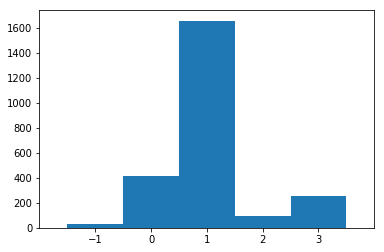

In [589]:
bins = np.arange(-2,5) - 0.5
h, x, _ = plt.hist(all_kp[octave_lvl][5], bins)
plt.xticks(range(-1, 4))
plt.xlim([-2, 4])
plt.plot()

In [500]:
n_keypoints = np.sum([np.sum(all_kp[octave_lvl][5]==3) for octave_lvl in range(NB_OCTAVES)])
print(n_keypoints)

436


# Gradient magnitude and orientation for each image sample point at each scale



In [501]:
keypoints = np.zeros((n_keypoints, 4)) 

In [502]:
def compute_mag_ori(img, nb_octave_layers = NB_OCTAVE_LAYERS):
    mag = np.zeros((img.shape[0], img.shape[1]))
    ori = np.zeros((img.shape[0], img.shape[1]))
    for j in range(1, img.shape[0] - 1):
        for k in range(1, img.shape[1] - 1):
            mag[j, k] = ( ((img[j+1, k] - img[j-1, k]) ** 2) + ((img[j, k+1] - img[j, k-1]) ** 2) ) ** 0.5   
            ori[j, k] = (36 / (2 * np.pi)) * (np.pi + np.arctan2((img[j, k+1] - img[j, k-1]), (img[j+1, k] - img[j-1, k])))   
    return np.stack([mag]*nb_octave_layers,axis=-1), np.stack([ori]*nb_octave_layers,axis=-1)

In [503]:
mags, oris = [], []
for img in scaled_imgs:
    mag, ori = compute_mag_ori(img)
    mags.append(mag)
    oris.append(ori)

In [504]:
#we reduce the influence of large gradient magnitudes by thresholding the values in the unit fea- ture vector to each be no larger than 0.2, and then renor- malizing to unit length
#mags = [np.clip(mag, 0, 0.2)*5 for mag in mags]

In [505]:
def filter_kp(kp_list, mask=3):
    return filter(lambda l: l[-1] == mask, zip(kp_list[0], kp_list[1], kp_list[2], kp_list[-2]))

In [526]:
def compute_keypoints(octave_n, all_kp, mags, oris, scaled_imgs, sigmas, nb_octave_layers = NB_OCTAVE_LAYERS):
    img = scaled_imgs[octave_n]
    kp = filter_kp(all_kp[octave_n])
    keypoints = []
    neighs = {}
    for j, k, i, _ in kp:
        gaussian_window = multivariate_normal(mean=[j, k], cov=((1.5 * SIGMAS[octave_n][i]) ** 2))
        two_sd = np.floor(2 * 1.5 * SIGMAS[octave_n][i])
        orient_hist = np.zeros([36,1])
        neigh = []
        for x in range(int(-1 * two_sd * 2), int(two_sd * 2) + 1):
            ylim = int((((two_sd * 2) ** 2) - (np.absolute(x) ** 2)) ** 0.5) #circle radius
            for y in range(-1 * ylim, ylim + 1):
                if j + x < 0 or j + x > img.shape[0] - 1 or k + y < 0 or k + y > img.shape[1] - 1: #out of range
                    continue
                weight = mags[octave_n][j + x, k + y, i-1] * gaussian_window.pdf([j + x, k + y])
                bin_idx = np.clip(np.floor(oris[octave_n][j + x, k + y, i-1]), 0, 35)
                orient_hist[bin_idx.astype(np.int8)] += weight
                neigh.append((x,y,weight,bin_idx))
        
                
        scale = 2**(octave_n - 1)
        neighs[(int(j * scale), int(k * scale), i)] = neigh
        
        maxval = np.amax(orient_hist)
        maxidx = np.argmax(orient_hist)
        kp_descriptors = [maxidx]
        
        orient_hist[maxidx] = 0
        newmaxval = np.amax(orient_hist)
        while newmaxval > 0.8 * maxval:
            newmaxidx = np.argmax(orient_hist)
            kp_descriptors.append(newmaxidx)
            orient_hist[newmaxidx] = 0
            newmaxval = np.amax(orient_hist)
        keypoints.append([int(j * scale), int(k * scale), i, kp_descriptors])
    return keypoints, neighs

In [527]:
keypoints = []
neighs = []
for octave_n in range(NB_OCTAVES):
    kp, nei = compute_keypoints(octave_n, all_kp, mags, oris, scaled_imgs, SIGMAS)
    keypoints.append(kp)
    neighs.append(nei)

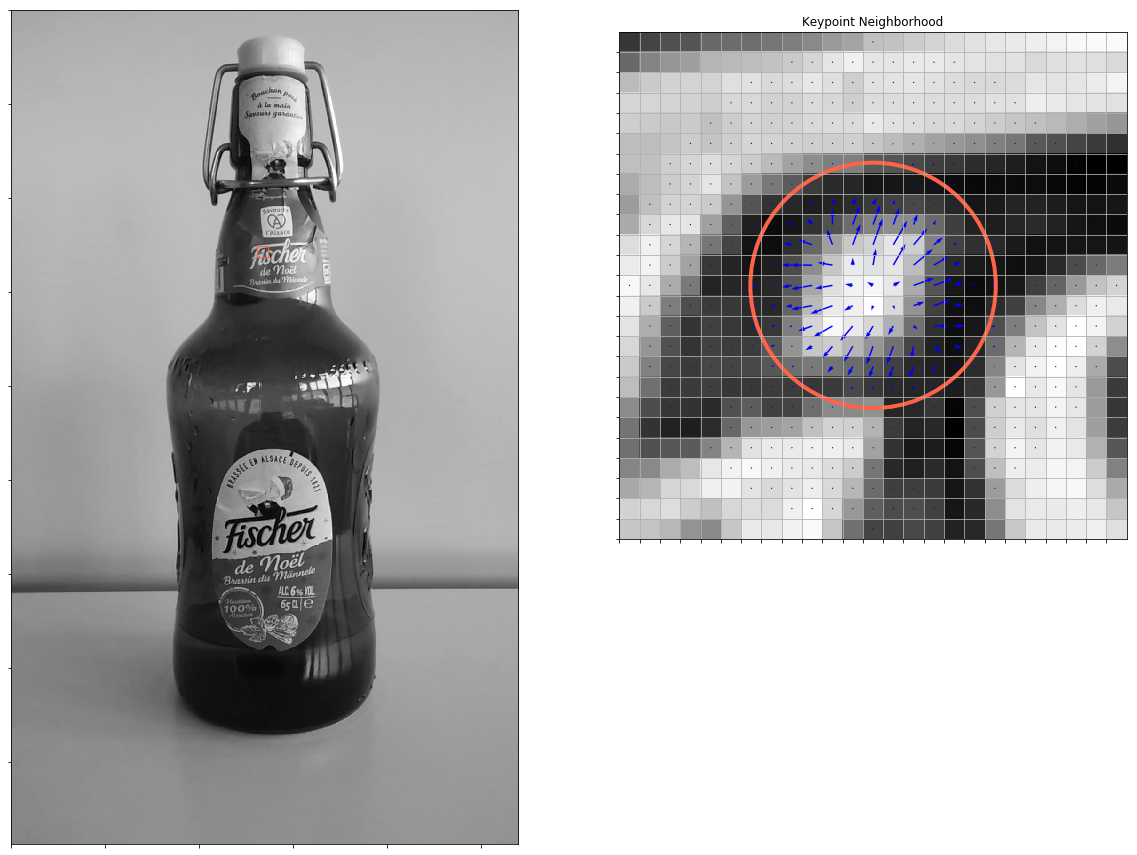

In [528]:
def plot_keypoint_neigh(keypoint, neigh, img, sigma):
    fig = plt.subplots(figsize=(20,20))
    gs = gridspec.GridSpec(4, 2)
    ax_im = plt.subplot(gs[:, 0])
    ax_im.imshow(img, cmap='gray')
    ax = plt.subplot(gs[:-1,1])
    ax.grid()
    
    x, y, weight, orientation = list(zip(*neigh))
    x = np.array(x)
    y = np.array(y)
    weight = np.array(weight)
    orientation = np.array(orientation)
    
    xmin, xmax = keypoint[0] + x.min(), keypoint[0] + x.max()
    ymin, ymax = keypoint[1] + y.min(), keypoint[1] + y.max()
    ax.imshow(img[xmin:xmax+1, ymin:ymax+1], cmap='gray', extent = (x.min()-0.5,x.max()+0.5,y.min()-0.5,y.max()+0.5))
    
    rect = patches.Rectangle((ymin,xmin),ymax-ymin,xmax-xmin,linewidth=1,edgecolor='tomato',facecolor='none')

    # Add the patch to the Axes
    ax_im.add_patch(rect)
    
    u = weight * np.cos(np.pi / 18.0 * orientation)
    v = weight * np.sin(np.pi / 18.0 * orientation)
    ax.quiver(x, y, u, v, scale=0.08,color='blue')
    
    circle = plt.Circle((0,0), 2* 1.5 * sigma, color='tomato', fill= False,lw=4)
    ax.add_artist(circle)
    
    plt.xticks(np.arange(x.min()-0.5,x.max()+0.5,1))
    plt.yticks(np.arange(y.min()-0.5,y.max()+0.5,1))

    ax.set(aspect=1, title='Keypoint Neighborhood')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_im.set_xticklabels([])
    ax_im.set_yticklabels([])
    
        
    plt.show()

octave_n = 0
plot_keypoint_neigh((514, 536, 1), neighs[octave_n][(514//2, 536//2, 1)], scaled_imgs[0], SIGMAS[octave_n][1])

In [509]:
def compute_global_mag_ori(scaled_imgs, mags, oris, nb_octave = NB_OCTAVES):
    n_octave_layers = mags[0].shape[-1]
    w, h = scaled_imgs[1].shape
    
    magpyr = np.zeros((w, h, nb_octave*n_octave_layers))
    oripyr = np.zeros((w, h, nb_octave*n_octave_layers))
    
    for i in range(n_octave_layers):
        magmax = np.amax(mags[0][:, :, i])
        magpyr[:, :, i] = misc.imresize(mags[0][:, :, i], (w, h), "bilinear").astype(float)
        magpyr[:, :, i] = (magmax / np.amax(magpyr[:, :, i])) * magpyr[:, :, i]  
        oripyr[:, :, i] = misc.imresize(oris[0][:, :, i], (w, h), "bilinear").astype(int)    
        oripyr[:, :, i] = ((36.0 / np.amax(oripyr[:, :, i])) * oripyr[:, :, i]).astype(int)

    for j in range(1, nb_octave):
        for i in range(n_octave_layers):
            if j == 1:
                magpyr[:, :, i+j*n_octave_layers] = (mags[j][:, :, i]).astype(float)
                oripyr[:, :, i+j*n_octave_layers] = (oris[j][:, :, i]).astype(int)   
            else:
                magpyr[:, :, i+j*n_octave_layers] = misc.imresize(mags[j][:, :, i], (w, h), "bilinear").astype(int)   
                oripyr[:, :, i+j*n_octave_layers] = misc.imresize(oris[j][:, :, i], (w, h), "bilinear").astype(int) 
                
    return magpyr, oripyr


def compute_descriptors(kps, magpyr, oripyr, n_octave_layers = NB_OCTAVE_LAYERS):
    #descriptors = np.zeros([keypoints.shape[0], 128])
    descriptors = []
    keypoints = []
    for octave, octave_kp in enumerate(kps):
        for kp in octave_kp:
            x0, y0 = kp[0], kp[1]
            scale_idx = kp[2] - 1 + octave*n_octave_layers
            for orientation in kp[3]:
                theta = 10 * orientation * np.pi / 180.0
                descriptor = np.zeros(128)
                for x in range(-8, 8):
                    for y in range(-8, 8):
                        xrot = int(np.round((np.cos(theta) * x) - (np.sin(theta) * y)))
                        yrot = int(np.round((np.sin(theta) * x) + (np.cos(theta) * y)))
                        gaussian_window = multivariate_normal(mean=[x0,y0], cov=8)
                        weight = magpyr[x0 + xrot, y0 + yrot, scale_idx] * gaussian_window.pdf([x0 + xrot, y0 + yrot])
                        angle = oripyr[x0 + xrot, y0 + yrot, scale_idx] - orientation
                        if angle < 0:
                            angle = 36 + angle
                            
                        bin_idx = np.clip(np.floor((8.0 / 36) * angle), 0, 7).astype(int)
                        descriptor[32 * int((x + 8)/4) + 8 * int((y + 8)/4) + bin_idx] +=weight
                descriptor = descriptor / LA.norm(descriptor) 
                descriptor = np.clip(descriptor, 0, 0.2)
                descriptor = descriptor / LA.norm(descriptor)
                descriptors.append(descriptor)
                keypoints.append(np.array([x0, y0, SIGMAS[octave][kp[2]], orientation]))
    return keypoints, descriptors

In [510]:
magpyr, oripyr = compute_global_mag_ori(scaled_imgs, mags, oris)
keypoints_, descriptors = compute_descriptors(keypoints, magpyr, oripyr)

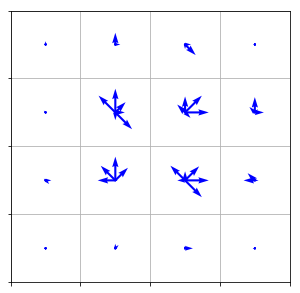

In [542]:
def plot_descriptor(descriptor):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid()
    
    for i in range(4):
        for j in range(4):
            x, y = 0.5 + j, 0.5 + i
            weights = descriptor[32 * j + 8 * i : 32 * j + 8 * i + 8]
            orientations = np.linspace(0,2*np.pi,9)[:-1]
            u = weights * np.cos(orientations)
            v = weights * np.sin(orientations)
            ax.quiver(x, y, u, v, scale=3,color='blue')
    plt.xticks(np.arange(0,5))
    plt.yticks(np.arange(0,5))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
     
    plt.show()
plot_descriptor(descriptors[58])

In [537]:
def kps(x,y):
    return list(filter(lambda v: v[1][0]==x and v[1][1]==y, enumerate(keypoints_)))

In [538]:
kps(514//2,536//2)

[(58, array([257.        , 268.        ,   2.01587368,   7.        ]))]